# Análise de Componentes Principais (PCA)

## 1. Definição das propriedades a serem utilizadas

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import img_props

def correct_image(img):
    '''Corrige dois problems observados na base de dados: 1. Algumas imagens
       apresentam conjuntos de pixels brancos separados do objeto principal. 
       Portanto precisamos encontrar e manter apenas o maior componente conexo
       nessas imagens. 2. Em algumas imagens, o objeto não está preenchido.
       Portanto, precisamos preenchê-los.'''
    
    img = np.pad(img, 1)
    
    # Obtenção do maior componente conexo utilizando funções do scipy
    img_lab, num_comp = ndi.label(img, np.ones((3,3)))
    tam_comps = ndi.sum(img, img_lab, range(1, num_comp+1))
    index_largest_comp = np.argmax(tam_comps) + 1
    img_largest_comp = img_lab==index_largest_comp

    # Obtenção do maior componente conexo de background. A ideia é
    # que buracos no interior do objeto representam componentes conexos
    # pequenos, que serão eliminados se apenas o maior componente de
    # background for mantido
    img_inv = np.logical_not(img_largest_comp)   # Inverte a imagem
    img_lab, num_comp = ndi.label(img_inv, np.ones((3,3)))
    tam_comps = ndi.sum(img_inv, img_lab, range(1, num_comp+1))
    index_largest_comp = np.argmax(tam_comps) + 1
    img_largest_comp_filled = img_lab==index_largest_comp 
    
    # Inverte novamente a imagem
    img_largest_comp_filled = np.logical_not(img_largest_comp_filled)  
    img_largest_comp_filled = img_largest_comp_filled[1:-1, 1:-1]
    
    return img_largest_comp_filled.astype(np.uint8)
      

## 2. Obtenção das propriedades das imagens da base

In [19]:
input_folder = 'imagens/'
files = sorted(os.listdir(input_folder))    # Lista todos os arquivos no diretório input_folder
num_files = len(files)

measurements = np.zeros((num_files, 4))
for file_index, file in enumerate(files):
    img = plt.imread(input_folder+file)
    img = (img>0).astype(np.uint8)
    
    # Se a imagem possuir 3 dimensões, é porque ela não possui apenas
    # 1 canal. Nesse caso, mantemos apenas o primeiro canal
    if img.ndim==3:
        img = img[:,:,0]
    
    img_corrected = correct_image(img)
    
    circularity = img_props.get_circularity(img_corrected)
    dist_to_centroid = img_props.get_distance_to_centroid(img_corrected)
    props = img_props.get_distance_to_centroid_props(dist_to_centroid)
    max_dist_to_centroid, min_dist_to_centroid, std_dist_to_centroid = props
    
    measurements[file_index] = [circularity, max_dist_to_centroid, 
                                min_dist_to_centroid, std_dist_to_centroid]
    

A variável measurements é uma matriz na qual cada linha representa uma imagem e cada coluna uma propriedade calculada. Ou seja, cada linha dessa matriz representa uma imagem localizada em um espaço de atributos 4 dimensões (pois a matriz tem 4 colunas).

In [20]:
corr_mat = np.corrcoef(measurements.T)
print(corr_mat)

[[ 1.          0.08009629  0.34296897  0.13511862]
 [ 0.08009629  1.         -0.32153962  0.78060863]
 [ 0.34296897 -0.32153962  1.         -0.61117118]
 [ 0.13511862  0.78060863 -0.61117118  1.        ]]


## 3. Aplicação do PCA implementado na biblioteca scikit-learn

Vamos aplicar o PCA para definir 2 novos atributos. Veremos se esses 2 atributos podem ser utilizados para separar as duas categorias de imagens.

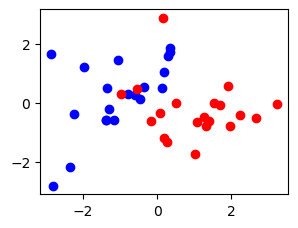

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale    # z-score

# Normaliza medidas, de forma que cada coluna de measurements_norm
# possui média 0 e desvio padrão 1
measurements_norm = scale(measurements, axis=0)

# Cria instância da classe PCA, com projeção em 2 eixos (2D), e aplica
# o PCA nos dados
pca_instance = PCA(n_components=2)
proj_data = pca_instance.fit_transform(measurements_norm)

# Plota cada metade dos pontos com uma cor diferente
plt.plot(proj_data[:20,0], proj_data[:20,1], 'bo')
plt.plot(proj_data[20:,0], proj_data[20:,1], 'ro')

In [10]:
print(pca_instance.explained_variance_ratio_)
print(pca_instance.components_)

[0.54083926 0.30803046]
[[ 0.03525952 -0.57056593  0.50700054 -0.64510598]
 [ 0.84257226  0.25255162  0.44373801  0.17142417]]
